In [1]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable double precision (very important)
from functools import partial
import matplotlib.pyplot as plt

In [2]:
# define some scalar base kernel

def rbf(x1, x2, lengthscale=1.0):
    return jnp.exp(-0.5 * jnp.sum((x1-x2)**2) / lengthscale**2)

# define operators as higher-order functions

def identity(f):
    return f

def div(f):
    # f: R^n -> R^n
    def divf(x):
        return jnp.trace(jax.jacobian(f)(x))
    return divf

def laplacian(f):
    return div(jax.grad(f))

def disknormal_derivative(f):
    def df_dn(x):
        n = x / jnp.linalg.norm(x) # normal vectors on a zero-centered disk are easy
        return jax.jvp(f, (x,), (n,))[1]
    return df_dn

boundary_function = lambda x: jnp.cos(5*jnp.arctan2(x[1], x[0]))

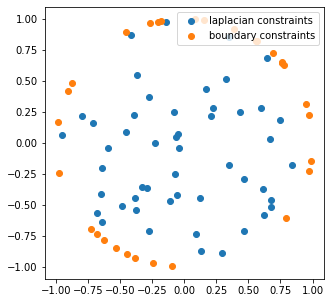

In [3]:
radius = 1.0
n_interior = 50
n_boundary = 30
rng = jax.random.PRNGKey(1234)
rng, key1, key2, key3 = jax.random.split(rng, 4)
x_interior = jax.vmap(lambda r, theta:   r * jnp.array([jnp.cos(theta), jnp.sin(theta)]))(radius * jnp.sqrt(jax.random.uniform(key1, (n_interior,))), jax.random.uniform(key2, (n_interior,)) * 2 * jnp.pi)
x_boundary = jax.vmap(lambda theta: radius * jnp.array([jnp.cos(theta), jnp.sin(theta)]))(jax.random.uniform(key3, (n_boundary,)) * 2 * jnp.pi)
plt.figure(figsize=(5,5))
plt.scatter(*x_interior.T, label="laplacian constraints")
plt.scatter(*x_boundary.T, label="boundary constraints")
plt.legend(loc="upper right")

In [4]:
from opgp import build_solve, build_predict, build_predict_scalar, residual

k = partial(rbf, lengthscale=0.1)
operators = {"laplacian": laplacian, "neumann": disknormal_derivative}
x = {"laplacian": x_interior, "neumann": x_boundary}
observations = {
    "laplacian": jnp.zeros(len(x_interior)), 
    "neumann": jax.vmap(boundary_function)(x_boundary)
}
solve = build_solve(k, operators)
predict = build_predict(k, operators, operators)
alphas = solve(x, observations)
print("alphas", jax.tree_map(jnp.shape, alphas))

u = build_predict_scalar(k, operators, x, alphas)
residual(u, x, operators, observations)

alphas {'laplacian': (50,), 'neumann': (30,)}


{'laplacian': DeviceArray(2.56383518e-06, dtype=float64),
 'neumann': DeviceArray(1.44632345e-06, dtype=float64)}

# baselines

In [5]:
def boundary_only():
    k = partial(rbf, lengthscale=0.1)
    ops = {"neumann": operators["neumann"]}
    x_boundary_only = {"neumann": x["neumann"]}
    obs = {"neumann": observations["neumann"]}
    solve = build_solve(k, ops)
    alphas = solve(x_boundary_only, obs)
    print("alphas", jax.tree_map(jnp.shape, alphas))
    u = build_predict_scalar(k, ops, x, alphas)
    return u

u_boundary_only = boundary_only()
residual(u_boundary_only, x, operators, observations)

alphas {'neumann': (30,)}


{'laplacian': DeviceArray(1.93779405, dtype=float64),
 'neumann': DeviceArray(7.65197631e-07, dtype=float64)}

In [6]:
dx = jnp.linspace(-radius, radius, 20)
# x_dense_interior = jnp.stack(jnp.meshgrid(dx, dx, axis=-1)).reshape(-1, 2)
x_dense_interior = jnp.stack(jnp.meshgrid(dx, dx), axis=-1).reshape(-1, 2)
x_dense_interior = x_dense_interior[jax.vmap(jnp.linalg.norm)(x_dense_interior) < radius]
radial = lambda theta: radius * jnp.array([jnp.cos(theta), jnp.sin(theta)])
x_dense_boundary = jax.vmap(radial)(jnp.linspace(0,2*jnp.pi,num=100))

def baseline():
    k = partial(rbf, lengthscale=0.1)
    operators = {"laplacian": laplacian, "neumann": disknormal_derivative}
    x = {"laplacian": x_dense_interior, "neumann": x_dense_boundary}
    observations = {
        "laplacian": jnp.zeros(len(x_dense_interior)), 
        "neumann": jax.vmap(boundary_function)(x_dense_boundary)
    }
    solve = build_solve(k, operators)
    predict = build_predict(k, operators, operators)
    alphas = solve(x, observations)
    print("alphas", jax.tree_map(jnp.shape, alphas))
    u = build_predict_scalar(k, operators, x, alphas)
    print(residual(u, x, operators, observations))
    return u

u_baseline = baseline()
residual(u_baseline, x, operators, observations)

alphas {'laplacian': (276,), 'neumann': (100,)}
{'laplacian': DeviceArray(1.49904161e-06, dtype=float64), 'neumann': DeviceArray(1.34590217e-06, dtype=float64)}


{'laplacian': DeviceArray(2.15310155, dtype=float64),
 'neumann': DeviceArray(2.72492997e-05, dtype=float64)}

(2, 276)


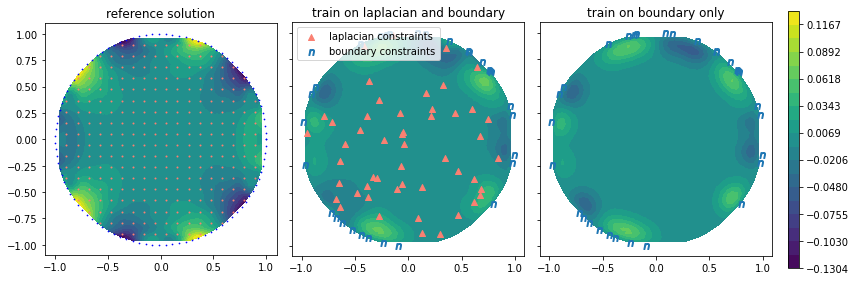

In [7]:
def plot():
    fig = plt.figure(figsize=(12,4))
    gs = plt.GridSpec(1,4, width_ratios=[4,4,4,0.2])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])

    x_test = jnp.stack(jnp.meshgrid(jnp.linspace(-radius, radius, 50), jnp.linspace(-radius, radius, 50)), axis=-1).reshape(-1, 2)
    x_test = x_test[jax.vmap(jnp.linalg.norm)(x_test) < radius]

    ux = jax.vmap(u)(x_test)
    uboundaryx = jax.vmap(u_boundary_only)(x_test)
    ubaselinex = jax.vmap(u_baseline)(x_test)
    levels = jnp.linspace(
        min(a.min() for a in [ux, uboundaryx, ubaselinex]),
        max(a.max() for a in [ux, uboundaryx, ubaselinex]),
        num=20
    )

    ax1.set_title("reference solution")
    # TODO solve with a PDE package? or choose another PDE with analytical solution?
    ax1.tricontourf(*x_test.T, ubaselinex, levels=levels)
    ax1.scatter(*x_dense_interior.T, c="salmon", s=1)
    print(x_dense_interior.T.shape)
    ax1.scatter(*x_dense_boundary.T, c="blue", s=0.5)
    
    ax2.set_title("train on laplacian and boundary")
    c = ax2.tricontourf(*x_test.T, ux, levels=levels)
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.scatter(*x_interior.T, marker="^", label="laplacian constraints", color="salmon")
    ax2.scatter(*x_boundary.T, marker=r"$n$", label="boundary constraints")
    ax2.legend(loc="upper left")

    ax3.set_title("train on boundary only")
    c = ax3.tricontourf(*x_test.T, uboundaryx, levels=levels)
    plt.setp(ax3.get_yticklabels(), visible=False)
    ax3.scatter(*x_boundary.T, marker=r"$n$", label="boundary constraints")

    for ax in (ax1, ax2, ax3):
        ax.set_aspect(1)
    
    plt.colorbar(c, cax=ax4)
    plt.tight_layout()

    plt.close()
    return fig

fig = plot()
fig

In [8]:
fig.savefig("laplaceGP_neumann.pdf")

In [9]:
# TODO perhaps poisson would make a nicer example (with non-zero laplacian..) since RBF kernels are smoothing devices anyway and min-norm gets too similar to minimal surface :)

In [10]:
# TODO fenics baseline